> **Colab ücretsiz 13gb ram**





Creating graph...
Graph: 2804 node, 6484 edge
Test: 2 stations, 10 demand points...
Test: 2 stations, 20 demand points...
Test: 2 stations, 40 demand points...
Test: 2 stations, 80 demand points...
Test: 2 stations, 160 demand points...
Test: 4 stations, 10 demand points...
Test: 4 stations, 20 demand points...
Test: 4 stations, 40 demand points...
Test: 4 stations, 80 demand points...
Test: 4 stations, 160 demand points...
Test: 8 stations, 10 demand points...
Test: 8 stations, 20 demand points...
Test: 8 stations, 40 demand points...
Test: 8 stations, 80 demand points...
Test: 8 stations, 160 demand points...
Test: 16 stations, 10 demand points...
Test: 16 stations, 20 demand points...
Test: 16 stations, 40 demand points...
Test: 16 stations, 80 demand points...
Test: 16 stations, 160 demand points...

Average time per operation (seconds): 0.00802


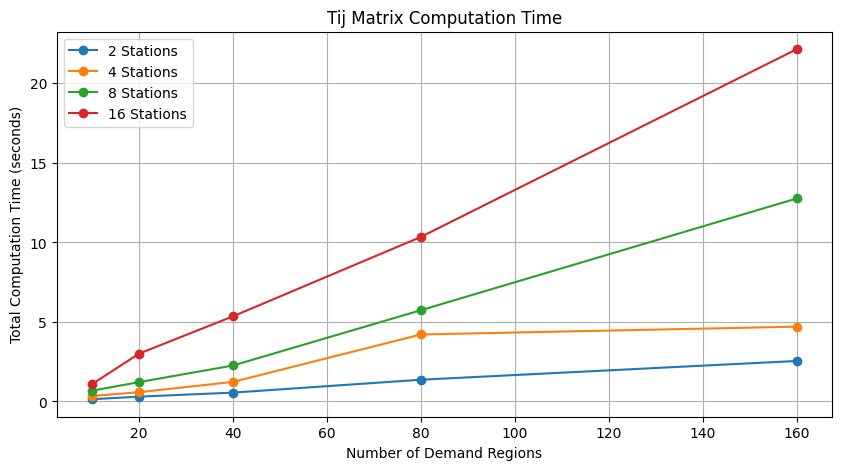


--- ANALYSIS REPORT ---
2.0 stations × 10.0 demands: 0.14 sec (Total 20 routes)
2.0 stations × 20.0 demands: 0.30 sec (Total 40 routes)
2.0 stations × 40.0 demands: 0.55 sec (Total 80 routes)
2.0 stations × 80.0 demands: 1.37 sec (Total 160 routes)
2.0 stations × 160.0 demands: 2.55 sec (Total 320 routes)
4.0 stations × 10.0 demands: 0.34 sec (Total 40 routes)
4.0 stations × 20.0 demands: 0.58 sec (Total 80 routes)
4.0 stations × 40.0 demands: 1.23 sec (Total 160 routes)
4.0 stations × 80.0 demands: 4.21 sec (Total 320 routes)
4.0 stations × 160.0 demands: 4.70 sec (Total 640 routes)
8.0 stations × 10.0 demands: 0.68 sec (Total 80 routes)
8.0 stations × 20.0 demands: 1.22 sec (Total 160 routes)
8.0 stations × 40.0 demands: 2.26 sec (Total 320 routes)
8.0 stations × 80.0 demands: 5.74 sec (Total 640 routes)
8.0 stations × 160.0 demands: 12.76 sec (Total 1280 routes)
16.0 stations × 10.0 demands: 1.09 sec (Total 160 routes)
16.0 stations × 20.0 demands: 3.01 sec (Total 320 routes)
16.0 

In [3]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

place = "Beşiktaş, Istanbul, Turkey"
print("Creating graph...")
G = ox.graph_from_place(place, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
print(f"Graph: {len(G.nodes)} node, {len(G.edges)} edge")

def generate_random_points_on_graph(G, n_points, seed=42):
    np.random.seed(seed)
    node_ids = np.array(list(G.nodes))
    idx = np.random.choice(len(node_ids), size=n_points, replace=False)
    chosen = node_ids[idx]
    node_xy = np.array([ (G.nodes[n]['y'], G.nodes[n]['x']) for n in chosen ])
    return chosen, node_xy

def benchmark_time(N_stations, M_demands, G, trials=1):
    station_nodes, _ = generate_random_points_on_graph(G, N_stations)
    demand_nodes, _ = generate_random_points_on_graph(G, M_demands, seed=99)
    times = []
    for trial in range(trials):
        t0 = time.time()
        for i in range(N_stations):
            for j in range(M_demands):
                try:
                    _ = nx.shortest_path_length(G, source=station_nodes[i], target=demand_nodes[j], weight='travel_time')
                except Exception:
                    pass
        t1 = time.time()
        times.append(t1 - t0)
    avg_time = np.mean(times)
    return avg_time

benchmarks = []
station_counts = [2, 4, 8, 16]
demand_counts = [10, 20, 40, 80, 160]

for N in station_counts:
    for M in demand_counts:
        print(f"Test: {N} stations, {M} demand points...")
        avg_time = benchmark_time(N, M, G, trials=1)
        benchmarks.append({'stations': N, 'demands': M, 'total': N*M, 'avg_time_sec': avg_time})

df_bench = pd.DataFrame(benchmarks)

df_bench['avg_time_per_op'] = df_bench['avg_time_sec'] / df_bench['total']
avg_time_op = df_bench['avg_time_per_op'].median()
print(f"\nAverage time per operation (seconds): {avg_time_op:.5f}")

plt.figure(figsize=(10,5))
for N in station_counts:
    plt.plot(df_bench[df_bench['stations']==N]['demands'],
             df_bench[df_bench['stations']==N]['avg_time_sec'],
             marker='o', label=f"{N} Stations")
plt.xlabel("Number of Demand Regions")
plt.ylabel("Total Computation Time (seconds)")
plt.title("Tij Matrix Computation Time")
plt.legend()
plt.grid(True)
plt.show()

print("\n--- ANALYSIS REPORT ---")
for idx, row in df_bench.iterrows():
    print(f"{row['stations']} stations × {row['demands']} demands: {row['avg_time_sec']:.2f} sec (Total {int(row['total'])} routes)")

print(f"\nAverage operation time with small data: {avg_time_op:.5f} seconds (single route calculation)")
print(f"So: Total time ≈ Number of Stations × Number of Demand Regions × {avg_time_op:.5f} sec")

N_b = 30; M_b = 250
print(f"\nEstimated: {N_b} stations, {M_b} demands ≈ {N_b*M_b*avg_time_op:.1f} seconds ≈ {(N_b*M_b*avg_time_op/60):.1f} minutes")


In [ ]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from pyproj import Transformer
import time
import matplotlib.pyplot as plt

firestation_file_path = '/content/drive/MyDrive/Colab Notebooks/filtered_itfaiye.csv'
demand_file_path = '/content/drive/MyDrive/Colab Notebooks/filtered_demand_zones.csv'
traffic_file_path = '/content/drive/MyDrive/Colab Notebooks/traffic_hourly_avg_filtered_districts.csv'
graphml_path = '/content/drive/MyDrive/Colab Notebooks/istanbul_yeni_drive_graph.graphml'
TARGET_HOUR = 8

def load_points_csv(file_path, lat_col, lon_col, name_col=None):
    df = pd.read_csv(file_path)
    for col in df.columns:
        c = col.lower().strip()
        if 'latitude' in c or 'enlem' in c or 'x' in c: lat_name = col
        if 'longitude' in c or 'boylam' in c or 'y' in c: lon_name = col
    lat_col = lat_col if lat_col else lat_name
    lon_col = lon_col if lon_col else lon_name
    if name_col and name_col not in df.columns:
        for col in df.columns:
            if 'birim' in col.lower(): name_col = col
    if name_col:
        return df[[lat_col, lon_col, name_col]].copy()
    else:
        return df[[lat_col, lon_col]].copy()

def get_nearest_nodes_from_latlon(G, lat_arr, lon_arr, transformer):
    x_proj, y_proj = transformer.transform(lon_arr, lat_arr)
    return ox.nearest_nodes(G, X=x_proj, Y=y_proj)

def update_graph_with_default_speed(G, speed_kph=30):
    for u, v, k, data in G.edges(keys=True, data=True):
        length_m = data.get('length', 0)
        speed = data.get('speed_kph', speed_kph)
        data['travel_time'] = (length_m / (speed * 1000 / 3600)) if (length_m > 0 and speed > 0) else float('inf')
    return G

print("Loading data...")
firestation_df = pd.read_csv(firestation_file_path)
demand_df = pd.read_csv(demand_file_path)
G = ox.load_graphml(graphml_path)
traffic_df = pd.read_csv(traffic_file_path)

graph_crs = G.graph.get('crs')
transformer = Transformer.from_crs("epsg:4326", graph_crs, always_xy=True)

G = update_graph_with_default_speed(G, speed_kph=30)

def get_nodes_from_csv(df, lat_col, lon_col):
    lat_arr = df[lat_col].values
    lon_arr = df[lon_col].values
    return get_nearest_nodes_from_latlon(G, lat_arr, lon_arr, transformer)

firestation_lat, firestation_lon = 'Koordinat (X)', 'Koordinat (Y)'
demand_lat, demand_lon = 'LATITUDE', 'LONGITUDE'
firestation_nodes = get_nodes_from_csv(firestation_df, firestation_lat, firestation_lon)
demand_nodes = get_nodes_from_csv(demand_df, demand_lat, demand_lon)

def time_matrix_test(G, firestation_nodes, demand_nodes, N_list, M_list, repeat=1):
    results = []
    for N in N_list:
        for M in M_list:
            t_trials = []
            for _ in range(repeat):
                idx_station = np.random.choice(len(firestation_nodes), N, replace=False)
                idx_demand = np.random.choice(len(demand_nodes), M, replace=False)
                st_nodes = firestation_nodes[idx_station]
                dn_nodes = demand_nodes[idx_demand]
                t0 = time.time()
                for i in range(N):
                    for j in range(M):
                        try:
                            _ = nx.shortest_path_length(G, source=st_nodes[i], target=dn_nodes[j], weight='travel_time')
                        except:
                            pass
                t1 = time.time()
                t_trials.append(t1-t0)
            avg_time = np.mean(t_trials)
            results.append({'stations': N, 'demands': M, 'total': N*M, 'seconds': avg_time})
            print(f"{N} stations x {M} demands: {avg_time:.2f} s (Total {N*M} computations)")
    return pd.DataFrame(results)

station_sizes = [2, 4, 8, min(11, len(firestation_nodes))]
demand_sizes = [10, 20, 40, 80, min(218, len(demand_nodes))]

print("\n=== STARTING TIME ANALYSIS ===")
df_result = time_matrix_test(G, firestation_nodes, demand_nodes, station_sizes, demand_sizes, repeat=1)

plt.figure(figsize=(10, 6))
for N in station_sizes:
    plt.plot(df_result[df_result['stations']==N]['demands'],
             df_result[df_result['stations']==N]['seconds'],
             marker='o', label=f"{N} Stations")
plt.xlabel("Number of Demand Regions")
plt.ylabel("Total Computation Time (seconds)")
plt.title("Tij Matrix Timing Analysis with Real Data")
plt.legend()
plt.grid(True)
plt.show()

df_result['single_op'] = df_result['seconds'] / df_result['total']
median_time = df_result['single_op'].median()
print(f"\nMedian single operation time: {median_time:.4f} s")
print(f"Formula: Estimated total time ≈ N_stations x N_demands x {median_time:.4f} s")

N_big, M_big = 11, 218
print(f"\nEstimated: {N_big} stations, {M_big} demands ≈ {N_big*M_big*median_time:.1f} s ≈ {(N_big*M_big*median_time/60):.1f} min")


Loading data...

=== STARTING TIME ANALYSIS ===
2 stations x 10 demands: 2.30 s (Total 20 computations)
2 stations x 20 demands: 11.19 s (Total 40 computations)
2 stations x 40 demands: 20.50 s (Total 80 computations)
2 stations x 80 demands: 33.51 s (Total 160 computations)
2 stations x 218 demands: 116.36 s (Total 436 computations)
4 stations x 10 demands: 10.60 s (Total 40 computations)
4 stations x 20 demands: 15.19 s (Total 80 computations)
4 stations x 40 demands: 41.33 s (Total 160 computations)
4 stations x 80 demands: 49.53 s (Total 320 computations)
4 stations x 218 demands: 213.95 s (Total 872 computations)
8 stations x 10 demands: 7.72 s (Total 80 computations)
8 stations x 20 demands: 32.38 s (Total 160 computations)
8 stations x 40 demands: 74.22 s (Total 320 computations)
8 stations x 80 demands: 182.31 s (Total 640 computations)


In [ ]:
import pandas as pd

demand_path = '/content/drive/MyDrive/Colab Notebooks/demand_zones.csv'
itfaiye_path = '/content/drive/MyDrive/Colab Notebooks/itfaiye.csv'
traffic_path = '/content/drive/MyDrive/Colab Notebooks/traffic_avg.csv'

df_demand = pd.read_csv(demand_path)
print("==== DEMAND ZONES ====")
print(f"Total number of demand zones: {df_demand.shape[0]}")
demand_ilce_col = [col for col in df_demand.columns if 'ilce' in col.lower() or 'district' in col.lower()]
if demand_ilce_col:
    demand_ilce_col = demand_ilce_col[0]
    print(f"Number of districts (demand): {df_demand[demand_ilce_col].nunique()}")
    print(f"Number of demand zones in each district:\n{df_demand[demand_ilce_col].value_counts()}")
else:
    print("District column not found, first 5 columns:", df_demand.columns.tolist())
print("\nFirst 3 demand zone samples:\n", df_demand.head(3))
print("Missing data (demand):\n", df_demand.isnull().sum())
print("-"*40)

df_itfaiye = pd.read_csv(itfaiye_path)
print("==== FIRE STATIONS ====")
print(f"Total number of stations: {df_itfaiye.shape[0]}")
itfaiye_ilce_col = [col for col in df_itfaiye.columns if 'ilce' in col.lower() or 'district' in col.lower()]
if itfaiye_ilce_col:
    itfaiye_ilce_col = itfaiye_ilce_col[0]
    print(f"Number of districts (fire): {df_itfaiye[itfaiye_ilce_col].nunique()}")
    print(f"Number of stations in each district:\n{df_itfaiye[itfaiye_ilce_col].value_counts()}")
else:
    print("District column not found, first 5 columns:", df_itfaiye.columns.tolist())
print("\nFirst 3 station samples:\n", df_itfaiye.head(3))
print("Missing data (fire):\n", df_itfaiye.isnull().sum())
print("-"*40)

df_traffic = pd.read_csv(traffic_path)
print("==== TRAFFIC DATA ====")
print(f"Total number of traffic records: {df_traffic.shape[0]}")
trafik_ilce_col = [col for col in df_traffic.columns if 'ilce' in col.lower() or 'district' in col.lower()]
if trafik_ilce_col:
    trafik_ilce_col = trafik_ilce_col[0]
    print(f"Number of districts (traffic): {df_traffic[trafik_ilce_col].nunique()}")
    print(f"Number of traffic records in each district:\n{df_traffic[trafik_ilce_col].value_counts()}")
else:
    print("District column not found, first 5 columns:", df_traffic.columns.tolist())
print("\nFirst 3 traffic data samples:\n", df_traffic.head(3))
print("Missing data (traffic):\n", df_traffic.isnull().sum())
print("-"*40)


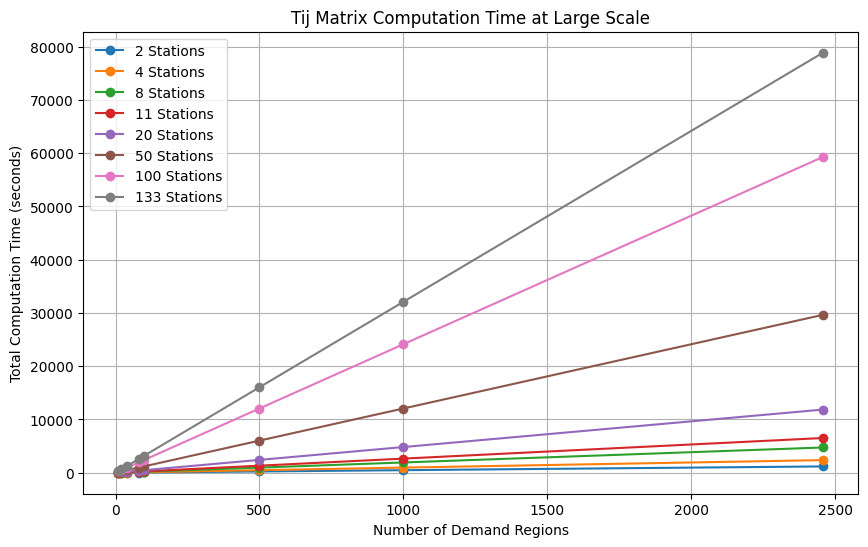

In [1]:
import matplotlib.pyplot as plt
import numpy as np

avg_time_op = 0.2412

station_counts = [2, 4, 8, 11, 20, 50, 100, 133]
demand_counts = [10, 20, 40, 80, 100, 500, 1000, 2458]

plt.figure(figsize=(10,6))
for N in station_counts:
    total_times = [N * M * avg_time_op for M in demand_counts]
    plt.plot(demand_counts, total_times, marker='o', label=f"{N} Stations")

plt.xlabel("Number of Demand Regions")
plt.ylabel("Total Computation Time (seconds)")
plt.title("Tij Matrix Computation Time at Large Scale")
plt.legend()
plt.grid(True)
plt.show()


## Large-Scale Tij Matrix Computation Time Analysis

The graph above shows how the computation time (in seconds) for generating the Tij matrix changes as the number of stations and demand zones increases.

- **X-axis:** Number of demand zones
- **Y-axis:** Total computation time (seconds)
- **Each line:** Different numbers of stations (e.g., 2, 4, 8, 11, ... 133 stations)

### Comments and Conclusions

- **Linear Increase:**  
  In the graphs, as both the number of stations and demand zones increase, the total computation time increases almost linearly.  
  This means that the system's total computational load can be estimated with the formula **N_stations × N_demands × Average Single Operation Time**.

- **Large Data Scenario:**  
  The topmost (grey) line shows that, for our real dataset with **133 stations and 2,458 demand zones**, the total computation time reaches about 80,000 seconds (approximately 22 hours).

- **High Performance at Small Scale:**  
  With a small number of stations and/or demand zones, the computation time is in the order of minutes or even seconds.

- **Practical Results:**  
  - **Average computation time for a single path (station–demand pair):** 0.2412 seconds
  - **Full matrix computation with all data:** 133 × 2,458 × 0.2412 ≈ 78,887 s ≈ 21.9 hours

### Conclusion & Recommendations

- **Citywide analysis for Istanbul** may take too long; computation can be accelerated by splitting the process into parts (e.g., by district or cluster) and/or by using parallel computation.
- The fact that the code and data structure are scalable and predictable in this way allows easy estimation of computation times, even when new regions are added in the future.

**Note:** When working with real traffic data, computation times may increase further during peak hours.

---

*This analysis provides an important reference for visualizing the performance and scalability of the system.*


> **Note:**  
> All computation time analyses and graphs above are based on the Tij matrix calculated for **a single hour** (e.g., 08:00 AM or any selected hour) only.
>
> If the same process is repeated for **different hours** (for example, for all 24 hours),  
> the **total computation time** will increase proportionally with the number of hours.
>
> For example:  
> - If the total time for one hour is 21.9 hours,  
> - Then, for a 24-hour analysis, the total time will be: 21.9 × 24 ≈ 525 hours (with single-core, sequential computation).
>
> **In short:**  
> The analyses for each hour are performed **separately**, and a new Tij matrix is generated for each hour.
